In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2.segment import fwd_and_cluster, semantic_segment, get_attn_density, multi_class_bboxes

import numpy as np
from skimage.color import label2rgb
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

torch.manual_seed(0)
PATCH_SIZE  = 14
FEAT_DIM = 384

/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _draw_bboxes(bbox_list, colours: List[str], ax) -> None:
    for i, bbox in enumerate(bbox_list):
        x0, y0, x1, y1 = bbox
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            linewidth=1,
            edgecolor=colours[i],
            facecolor="none",
        )
        ax.add_patch(rect)

In [3]:
from hr_dv2 import HighResDV2, torch_pca

net = HighResDV2("dinov2_vits14_reg", 4, pca_dim=-1, dtype=torch.float16)
#net = HighResDV2("dino_vits8", 4, pca_dim=-1, dtype=torch.float16) # can go to stride = 2 for vit8
#net = HighResDV2("vit_vits16", 4, pca_dim=128, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [4]:
shift_dists = [i for i in range(1, 3)]
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)

net.set_transforms(fwd, inv)

In [7]:
paths = ["data/v8.png", "figures/fig_data/blobs.jpg"]
feats, attns, segs, unrefined = [], [], [], []
img_arrs = []
merge_t = [1.0, 1.1]
for i in range(2):
    path = paths[i]
    _img = Image.open(path)
    _h, _w = _img.height, _img.width
    t = tr.closest_crop(_h, _w, 14, True)

    img_tensor, img = tr.load_image(path, t)
    img_arr = np.array(img)
    img_arrs.append(img_arr)
    h, w, c = img_arr.shape

    img_tensor.to(torch.float16)
    img_tensor = img_tensor.cuda()

    labels, centers, feat, attn, normed = fwd_and_cluster(
        net,
        img_tensor,
        80,
        attn_choice='o',
        sequential=False,
    )
    seg, _ = semantic_segment(
        normed, attn, labels, centers, img_arr, merge_t[i]
    )

    feats.append(feat)
    attns.append(attn)
    segs.append(seg)
    unrefined.append(_)

[37.417819906486805, 6.979514114546218, 13.770733348619197]
1
[0 1 2]
[0 1 3]
[33.92525058067411, 12.739357990719153, 17.982008273841856]
1
[0 1 2]
[0 1 3]


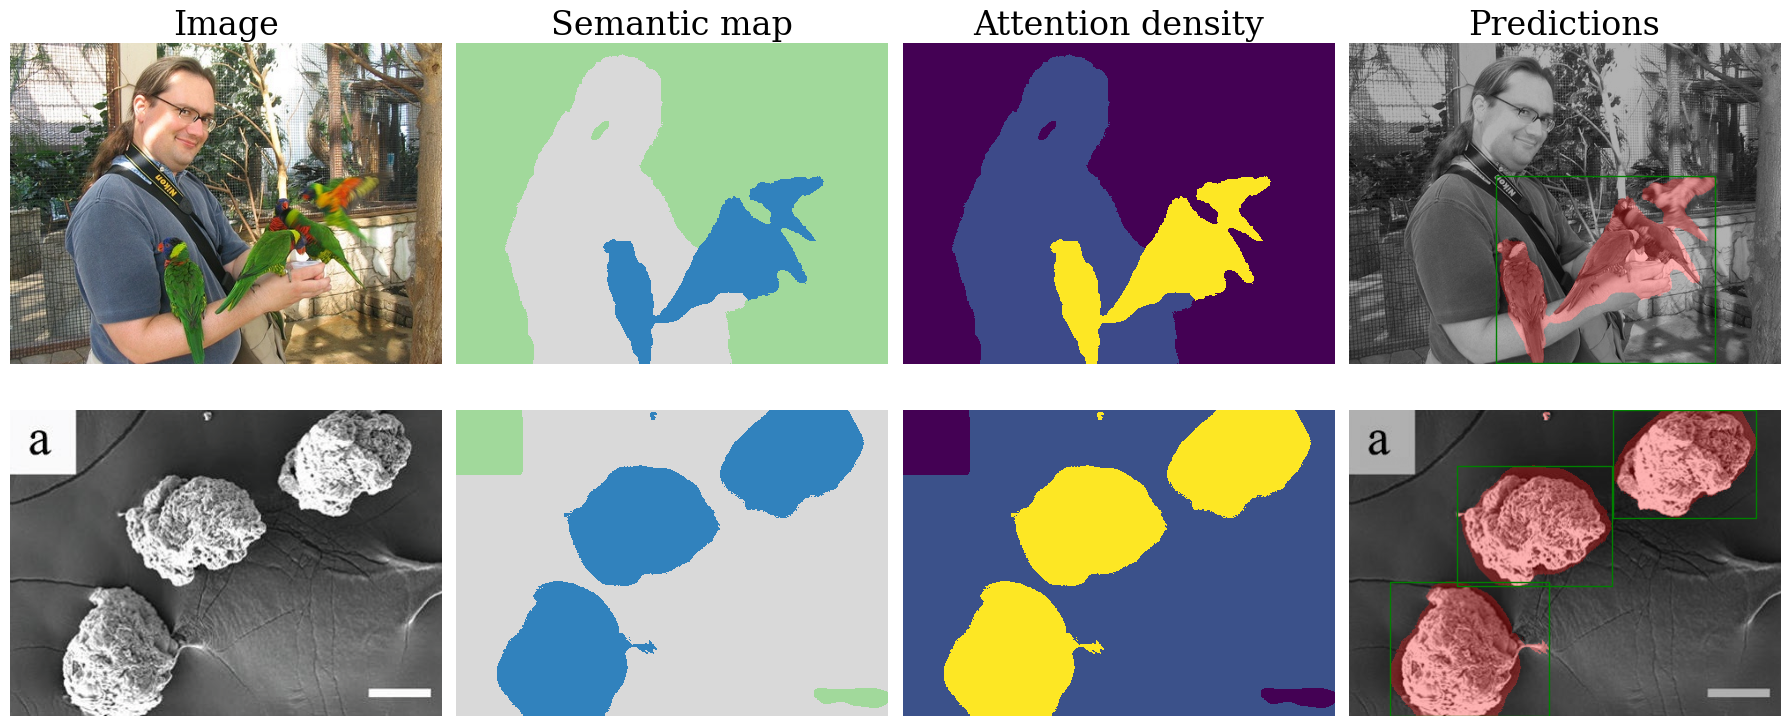

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(18, 8)
plt.rcParams["font.family"] = "serif"
for i in range(2):
    seg = segs[i]
    
    sum_cls = np.sum(attns[i], axis=0)
    amap, dens = get_attn_density(seg, sum_cls)
    print(dens)
    min_attn_class = np.argmin(dens)
    fg = amap > np.mean(dens)
    print(min_attn_class)

    axs[i, 0].imshow(img_arrs[i])
    axs[i, 1].imshow(seg, cmap='tab20c', interpolation='none')
    axs[i, 2].imshow(amap, interpolation='none')

    if i == 0:
        FS = 24
        axs[i, 0].set_title('Image', fontsize=FS)
        axs[i, 1].set_title('Semantic map', fontsize=FS)
        axs[i, 2].set_title('Attention density', fontsize=FS)
        axs[i, 3].set_title('Predictions', fontsize=FS)

    print(np.unique(seg))
    remapped = np.where(seg == min_attn_class, -1, seg)
    remapped += 1
    print(np.unique(remapped))

    relabelled = label2rgb(fg, img_arrs[i], bg_label=0)
    axs[i, 3].imshow(relabelled)
    bboxes = multi_class_bboxes(fg)
    _draw_bboxes(bboxes, ["g" for i in range(len(bboxes))], axs[i, 3])

    for ax in axs[i]:
        ax.set_axis_off()

plt.tight_layout()

voc12 2280, voc7 340?